In [4]:
from collections import defaultdict
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [5]:
def testAgent(n_episodes, agentClass, agentParams):
    env = gym.make("Blackjack-v1", sab=False)
    env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
    
    agent = agentClass(env, **agentParams)
    
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()
    
    # visualize the episode rewards, episode length and training error in one figure
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))

    # np.convolve will compute the rolling mean for 100 episodes
    axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
    axs[0].set_title("Episode Rewards")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Reward")

    axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Length")

    axs[2].plot(np.abs(np.convolve(agent.training_error, np.ones(100))))
    axs[2].set_title("Training Error")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Training Error")

    plt.tight_layout()
    plt.show()
    
    return env, agent

In [20]:
class QLearning:
    def __init__(
        self,
        env: gym.Env,
        lr: float,
        epsilon0: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma: float = 0.95,
    ):
        self.env = env
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = lr
        self.epsilon = epsilon0
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = gamma
        self.training_error = []
    
    def get_action(self, obs: tuple[int, int, bool]) -> int: # epsilon-greedy
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        future_q = (not terminated) * np.max(self.q[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q - self.q[obs][action]
        )

        self.q[obs][action] = (
            self.q[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

100%|██████████| 100000/100000 [00:06<00:00, 15316.52it/s]


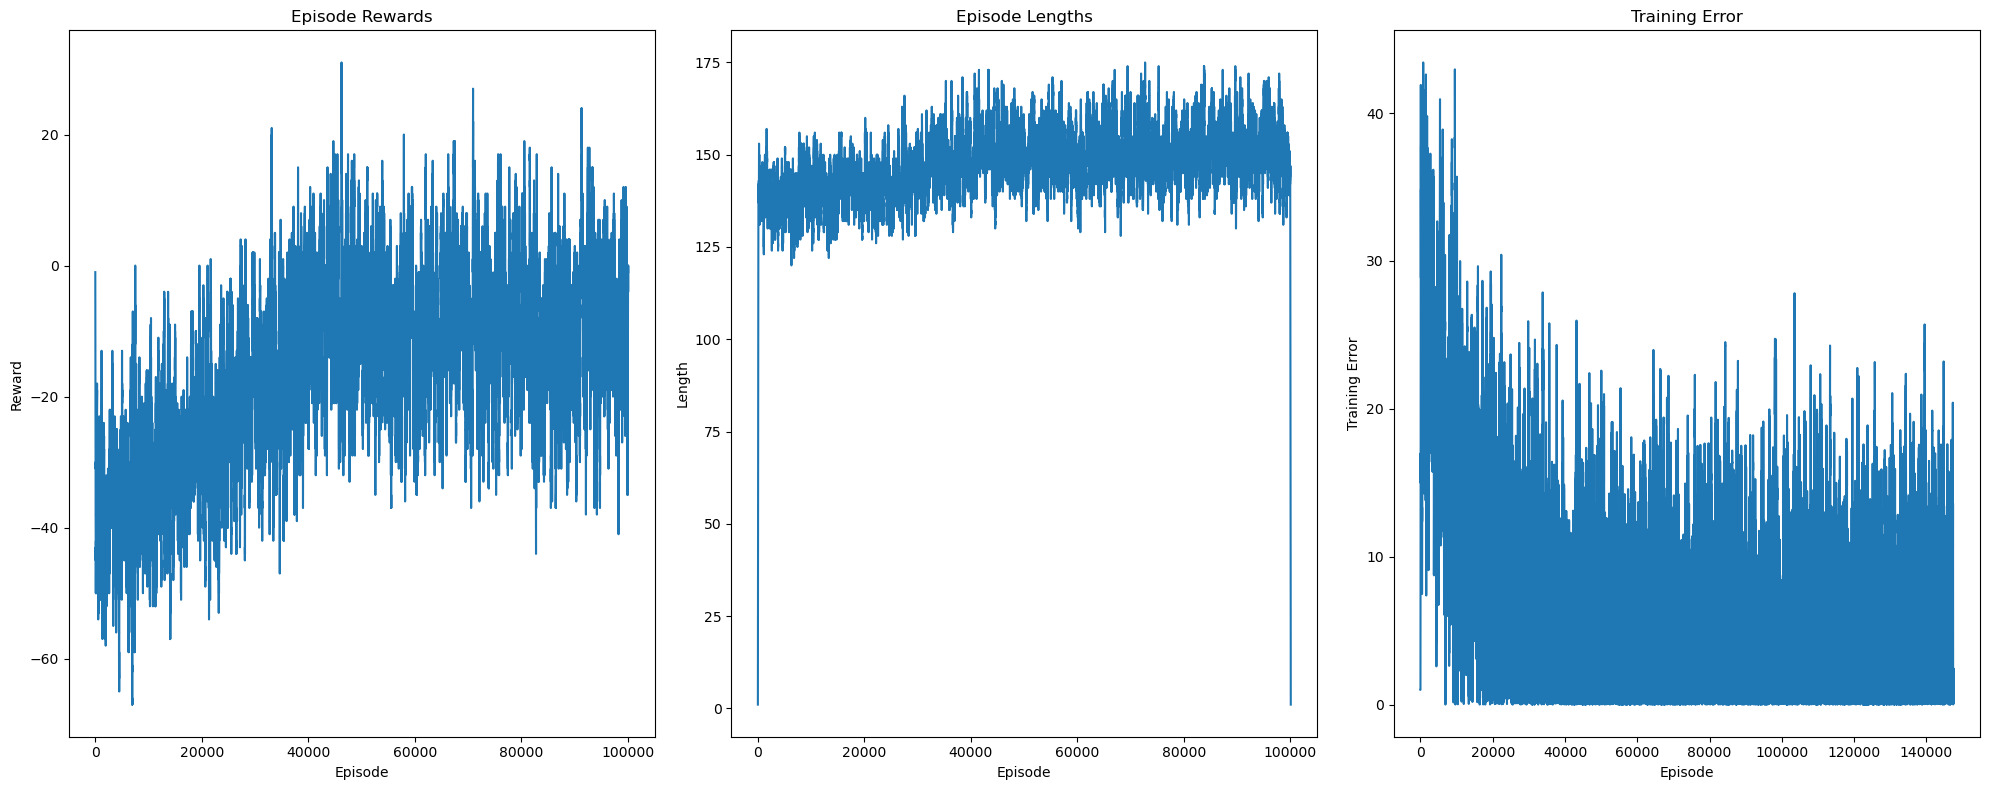

In [21]:
n_episodes = 100_000
qLearningParams0 = {
    'lr': 0.01,
    'epsilon0': 1.0,
    'epsilon_decay': 1.0 / (n_episodes / 2),
    'final_epsilon': 0.1,
}
env, qLearningAgent0 = testAgent(n_episodes, QLearning, qLearningParams0)

100%|██████████| 200000/200000 [00:12<00:00, 15506.82it/s]


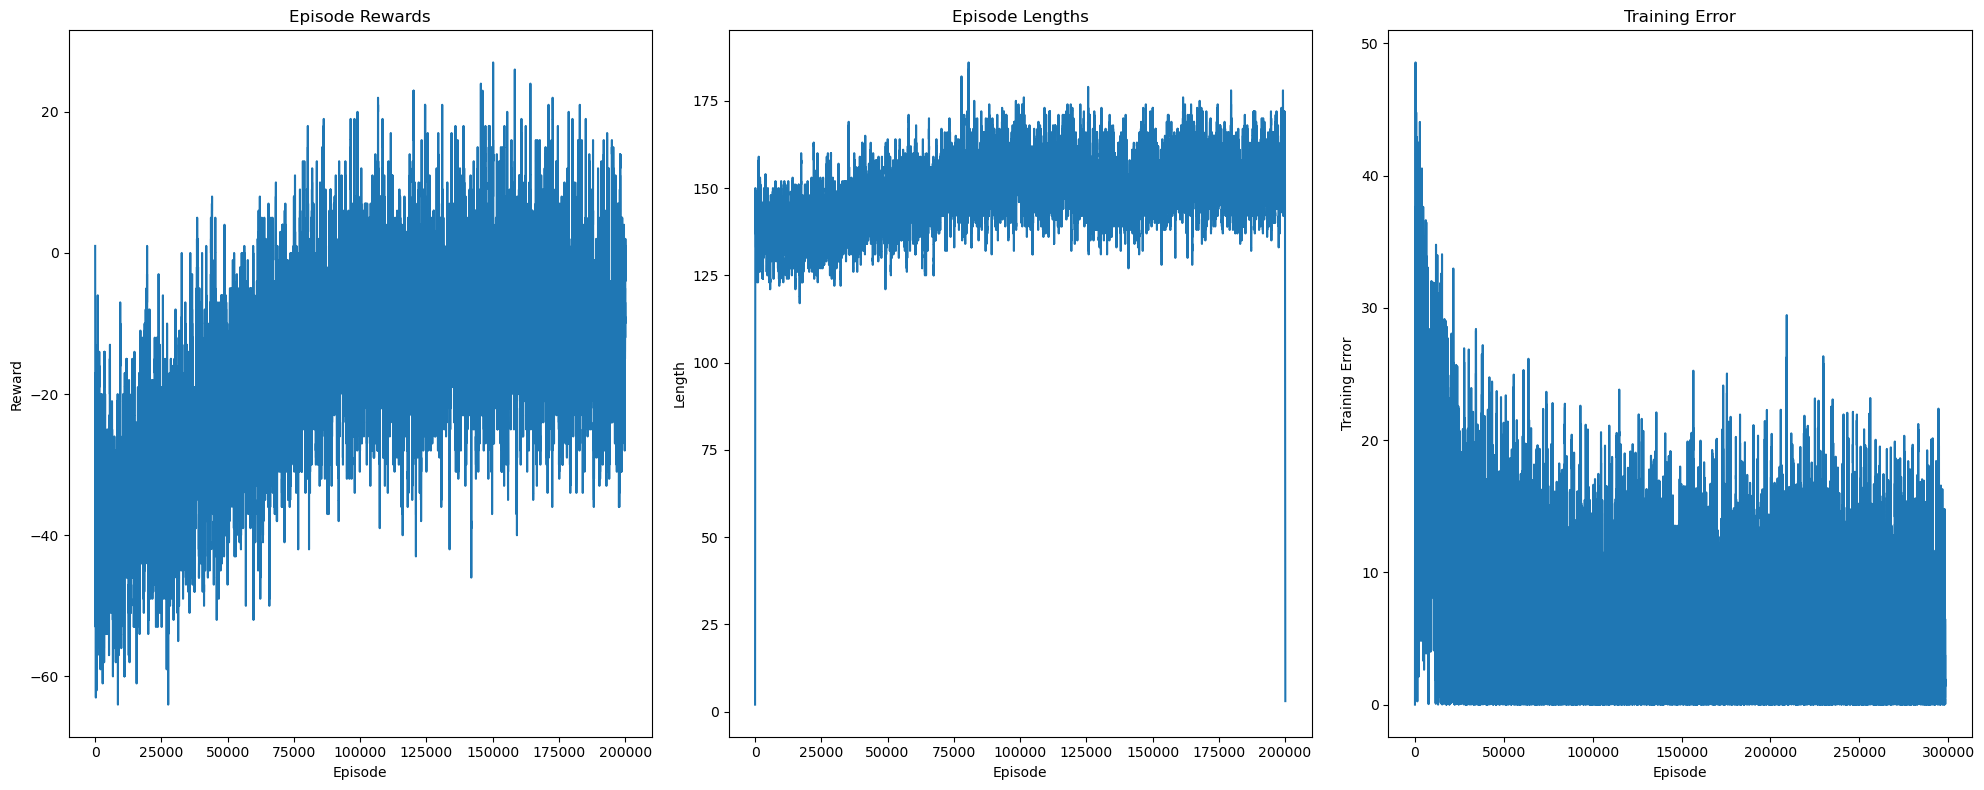

In [16]:
# train twice as long
n_episodes = 200_000
qLearningParams0 = {
    'lr': 0.01,
    'epsilon0': 1.0,
    'epsilon_decay': 1.0 / (n_episodes / 2), # stop exploring halfway through
    'final_epsilon': 0.1,
}
env, qLearningAgent0 = testAgent(n_episodes, QLearning, qLearningParams0)

In [22]:
class Sarsa:
    def __init__(
        self,
        env: gym.Env,
        lr: float,
        epsilon0: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma: float = 0.95,
    ):
        self.env = env
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = lr
        self.epsilon = epsilon0
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = gamma
        self.training_error = []
        self.next_action = None
    
    def get_action(self, obs: tuple[int, int, bool]) -> int: # epsilon-greedy
        if self.next_action == None:
            if np.random.random() < self.epsilon:
                return self.env.action_space.sample()
            else:
                return int(np.argmax(self.q[obs]))
        else:
            return self.next_action

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        self.next_action = None
        self.next_action = self.get_action(next_obs)
        
        td = reward + (not terminated) * self.discount_factor * self.q[next_obs][self.next_action] - self.q[obs][action]
        self.q[obs][action] += self.lr * td
        
        self.training_error.append(td)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

100%|██████████| 100000/100000 [00:05<00:00, 18516.85it/s]


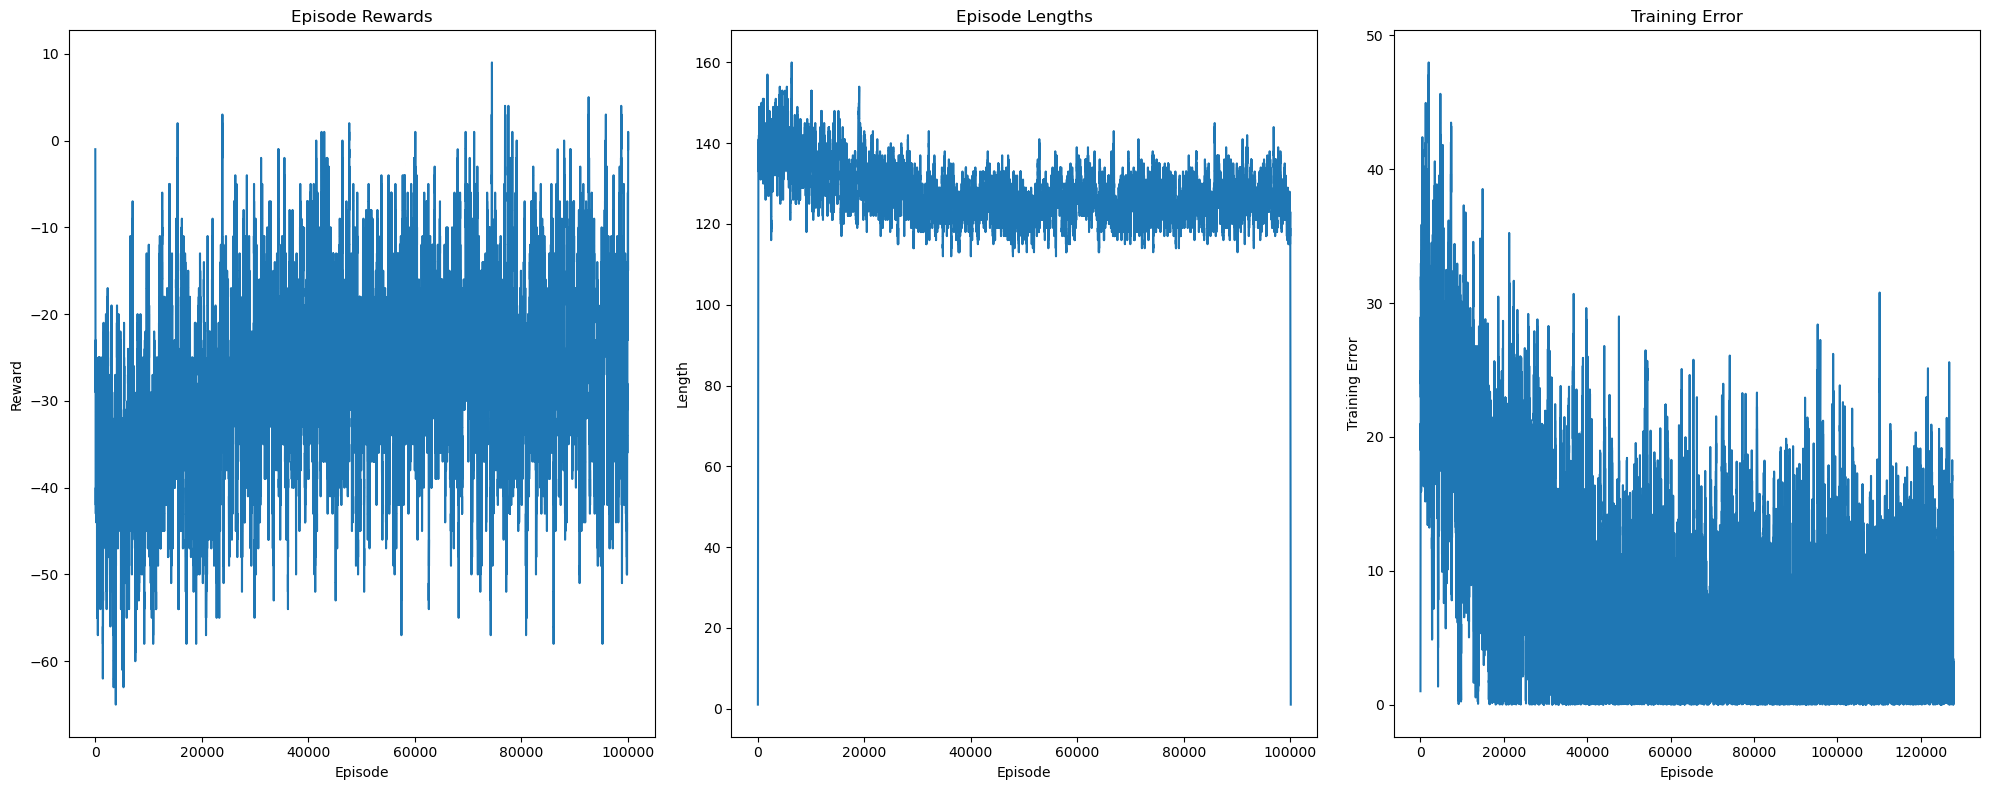

In [23]:
n_episodes =100_000
sarsaParams0 = {
    'lr': 0.01,
    'epsilon0': 1.0,
    'epsilon_decay': 1.0 / (n_episodes / 2), # stop exploring halfway through
    'final_epsilon': 0.1,
}
env, sarsaAgent0 = testAgent(n_episodes, Sarsa, sarsaParams0)